In [43]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from numpy import linalg as LA
%matplotlib inline

In [44]:
nhep = 0.01
PSF_experience = 1
PSF_procedures = 1
PSF_ergonomics = 1
PSF_workprocess =1
PSF_fitness = 1
hep = np.zeros (48)
c =0

for PSF_time in [1,0.1,0.01,.01]:
    for PSF_stress in [5,2,1]:
        for PSF_complexity in [5,2,1,0.1]: 
            hep[c]  = ((nhep * (PSF_time * PSF_stress * PSF_complexity* PSF_experience 
                *PSF_procedures*PSF_ergonomics*PSF_workprocess*PSF_fitness)) /(nhep * 
                ((PSF_time * PSF_stress * PSF_complexity* PSF_experience 
                *PSF_procedures*PSF_ergonomics*PSF_workprocess*PSF_fitness)-1)+1))
            c=c+1
            
joint_probability = np.zeros (48)
c =0
for PSF_time in [.42,0.54,0.03,.01]:
    for PSF_stress in [.03,.31,0.66]:
        for PSF_complexity in [.11,.67,.14,0.08]: 
            joint_probability[c] = PSF_time * PSF_complexity * PSF_stress
            c=c+1
            

df = pd.DataFrame({'Conditional HEP':hep,'Conditional joint probability':joint_probability})
df = df.sort_values('Conditional HEP').reset_index()
df.drop(['index'],axis=1,inplace=True)

step = []
for i in range (48):
    if i ==0:
        step.append( df['Conditional joint probability'][i]*(2790))
    if i>0:
        step.append( df['Conditional joint probability'][i]*2790 + sum(df['Conditional joint probability'][0:i-1]*2790))

list_mapping = []
index =[]
k=0
for line in range(1,187):
    for cmax in range(1,6):
        for cyber in range(1,4):
            index_i = (line-1)*15+3* (cmax-1) +cyber
            index.append(index_i)
            if index_i <= step[k]:
            #list_mapping.append {'index':index_i,'hep':df['Conditional HEP'][k]}
                list_mapping.append(df['Conditional HEP'][k])
            elif index_i >  step[k]:
            #list_mapping{'index':index_i,'hep':df['Conditional HEP'][k]}
                k=k+1
                if k >47:
                    k=47
                    list_mapping.append(df['Conditional HEP'][k])  
                else:
                    list_mapping.append(df['Conditional HEP'][k]) 
mapped_HEP = pd.DataFrame({'HEP':list_mapping})        
mapped_HEP['index'] = np.arange(0,2790)*2+1
mapped_HEP.set_index('index',inplace=True)
hep = np.array(mapped_HEP)

In [94]:
# initialize the parameters
cbr = []
test1 =[]
test2 =[]
Capa = [20,80,200,500,800]
C=len(Capa)
pstop =[]
pcontninue =[]
index_h =0
N =118
NumberOfLines =186
N_pc_max = 118
gamma =0.05
line_node_ratio = N/NumberOfLines
psi = np.zeros(NumberOfLines+1)
theta = np.zeros(NumberOfLines+1)
human_error = np.zeros(NumberOfLines+1)
a1 = np.zeros(NumberOfLines+1)
a2 = np.zeros(NumberOfLines+1)
a3 = np.zeros(NumberOfLines+1)
a4 = np.zeros(NumberOfLines+1)
b=0.6
r = 0.9
e=0.3
Epsilon =np.zeros(NumberOfLines+1)
Wf=0.5
Wcmax=.5
wpsi=0.5

deltaT =.1
human_ini = .01
cyber_transition_probability = [.5, .3, .2]
cyber = [0,1,2]
cyber_level = len(cyber) 
Q = np.zeros((2*C*NumberOfLines*cyber_level,2*C*NumberOfLines*cyber_level))
Q = np.zeros([6000,6000])
#interconnections_ratio =np.linspace(0,1,11)
interconnections_ratio =[0.5]
#interconnections_ratio = [0,0.1,0.2, 0.3,0.4, 0.5, 0.6,.7,0.8, 0.9, 1]
list_of_expected_line_failures_without_cyber =[]
list_of_expected_line_failures_medium_cyber =[]
list_of_expected_line_failures_high_cyber =[]
#lamda =1
#weights for transition to p_hc
a=2.22
b=1.52
c=0.52
d=0.03
w=[a,b,c,d]
for interconnection_ratio in interconnections_ratio:
        Q = np.zeros([6000,6000])
        # begin loop to calculate the transition Matrix for given parameters
        for i in range(1,NumberOfLines):
            # calculate theta for each new failures
            theta_org =(1-interconnection_ratio)+(interconnection_ratio*line_node_ratio*i)/N_pc_max 
            theta[i] = min(1,theta_org+list_mapping[index_h])
            #theta[i] = interconnection_ratio
            #calculate the a1...a4 parameters and epsillon for given r,e and theta

            a1[i] = max(0.4 - 0.25 * r - e *(0.2 - e) -  0.25 * theta[i],0.02)
            a2[i] = max(0.1- 0.05 * r - 0.1 * e*(0.2 - e) - 0.07 * theta[i],0.01)
            a3[i] = max(0.4 - 0.25 * r - e *(0.2 - e) -  0.25 * theta[i],0.02)
            a4[i] = max(0.1- 0.05 * r - 0.1 * e*(0.2 - e) - 0.07 * theta[i],0.01)  
            Epsilon[i] = max(0.01,(0.6 - 0.4* r - 0.5 * e - 0.3 * theta[i]))

            # calculate the pStop
            # pstop(F_i)
            if i<=int(a2[i]*NumberOfLines):
                f1=Epsilon[i] + a1[i]*( (a2[i]*NumberOfLines-i)/(a2[i]*NumberOfLines) )**4
            elif i>int(a2[i]*NumberOfLines) and i<=int(b*NumberOfLines):
                f1=Epsilon[i]
            elif i>int(b*NumberOfLines):
                pstop_temp = Epsilon[i] + ( (i-b*NumberOfLines)/(NumberOfLines-b*NumberOfLines))**4
                f1=min(1,pstop_temp)
            for j in [1,2]:
                if j==1:
                    for k in range (1,C+1):
                        for l in range(1,cyber_level+1):
                            index_h = (i-1)*15+3* (k-1) +l-1
                            #pstop(C_i)
                            pstop_cmax = a3[i]*( (Capa[k-1]-max(Capa))/max(Capa) )**4
                            f2 = max(a4[i], pstop_cmax)

                            # CALCULATE psi
                            
                            if l ==1:
                                
                                
                                #lamda =1- interconnection_ratio*.2
                                #psi = (lamda+((1-lamda)*i/NumberOfLines))
                                
                                
                                lamda =.1
                                #lamda = 0
                                psi = lamda*(interconnection_ratio- ((i*interconnection_ratio*line_node_ratio)/N_pc_max))
                                #psi = lamda*interconnection_ratio*(1- (math.exp(gamma*line_node_ratio*i)-1)\
                                 #                                      /(math.exp(gamma*N_pc_max)-1))
                               
                            if l ==2:
                                #lamda =.7- interconnection_ratio*.3
                                #psi = lamda+((0.7-lamda)*i/NumberOfLines)
                                lamda = .5
                                psi = lamda*(interconnection_ratio- ((i*interconnection_ratio*line_node_ratio)/N_pc_max))
                            
                                #psi = lamda*interconnection_ratio*(1- (math.exp(gamma*line_node_ratio*i)-1)\
                                    #                                  /(math.exp(gamma*N_pc_max)-1))
          
                            if l ==3:
                                
                                #lamda =.5- interconnection_ratio*.50
                                #psi = lamda+((.5- lamda)*i/NumberOfLines)    
                                lamda =.9
                                #lamda = 0
                                psi = lamda*(interconnection_ratio- ((i*interconnection_ratio*line_node_ratio)/N_pc_max))
                            
                                #psi = lamda*interconnection_ratio*(1- (math.exp(gamma*line_node_ratio*i)-1)\
                                       #                               /(math.exp(gamma*N_pc_max)-1))
          
                            
                            #weighted sum of pstop
                            cbr.append(psi)
                            #psi =0
                            
                            #pStable = max(0.01,(Wf*f1+Wcmax*f2)*psi*(1- list_mapping[index_h]))
                            pStable = (Wf*f1+Wcmax*f2)*(1-interconnection_ratio*psi)
                            #pStable = (Wf*f1+Wcmax*f2)*(1-0*list_mapping[index_h])*psi
                            #pStable = (Wf*f1+Wcmax*f2+wpsi*psi)*(1-list_mapping[index_h])
                            #test1.append((Wf*f1+Wcmax*f2)*psi)
                            #test2.append((Wf*f1+Wcmax*f2)*psi*(1- list_mapping[index_h])
                            #pstop.append(pStable)
                            #print(pStable)
                            if pStable>1:
                                pStable ==1

                            pCont = 1 -pStable
                            pcontninue.append(pCont)

                            # find the transition probabilities when there are new failures
                            # Pstop in transition matrix 
                            if k==1 and l ==1:
                                Q[ 2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                              2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+2]=pStable

                                pContSub=min(1,0.03+6e-7*(i+112)**3)

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1]= \
                                    pCont*(1-pContSub)*cyber_transition_probability[0]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+3]= \
                                    pCont*(1-pContSub)*cyber_transition_probability[1]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+5]= \
                                    pCont*(1-pContSub)*cyber_transition_probability[2]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+7]= \
                                    (pContSub*pCont*w[0]/sum(w))*cyber_transition_probability[0]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+9]= \
                                    (pContSub*pCont*w[0]/sum(w))*cyber_transition_probability[1]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+11]= \
                                    (pContSub*pCont*w[0]/sum(w))*cyber_transition_probability[2]
                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+13]= \
                                    (pContSub*pCont*w[1]/sum(w))*cyber_transition_probability[0]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+15]= \
                                    (pContSub*pCont*w[1]/sum(w))*cyber_transition_probability[1]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+17]= \
                                    (pContSub*pCont*w[1]/sum(w))*cyber_transition_probability[2]
                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+19]= \
                                    (pContSub*pCont*w[2]/sum(w))*cyber_transition_probability[0]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+21]= \
                                    (pContSub*pCont*w[2]/sum(w))*cyber_transition_probability[1]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+23]= \
                                    (pContSub*pCont*w[2]/sum(w))*cyber_transition_probability[2]
                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+25]= \
                                    (pContSub*pCont*w[3]/sum(w))*cyber_transition_probability[0]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+27]= \
                                    (pContSub*pCont*w[3]/sum(w))*cyber_transition_probability[1]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+29]= \
                                    (pContSub*pCont*w[3]/sum(w))*cyber_transition_probability[2]



                            # Pstop in transition matrix
                            if k==1 and l ==2:
                                Q[ 2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+2]=pStable

                                pContSub=min(1,0.03+6e-7*(i+112)**3)

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1]= \
                                    pCont*(1-pContSub)*(cyber_transition_probability[1]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))
                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+3]= \
                                    pCont*(1-pContSub)*(cyber_transition_probability[2]/ \
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+7]= \
                                (pContSub*pCont*w[0]/sum(w))*(cyber_transition_probability[1]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+9]= \
                                (pContSub*pCont*w[0]/sum(w))*(cyber_transition_probability[2]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))
                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+13]= \
                                (pContSub*pCont*w[1]/sum(w))*(cyber_transition_probability[1]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+15]= \
                                (pContSub*pCont*w[1]/sum(w))*(cyber_transition_probability[2]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))
                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+19]= \
                                (pContSub*pCont*w[2]/sum(w))*(cyber_transition_probability[1]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+21]= \
                                (pContSub*pCont*w[2]/sum(w))*(cyber_transition_probability[2]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))
                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+25]= \
                                (pContSub*pCont*w[3]/sum(w))*(cyber_transition_probability[1]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+27]= \
                                (pContSub*pCont*w[3]/sum(w))*(cyber_transition_probability[2]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))

                            # Pstop in transition matrix for cyber level 3
                            if k==1 and l ==3:
                                Q[ 2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                              2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+2]=pStable

                                pContSub=min(1,0.03+6e-7*(i+112)**3)

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1]= \
                                    pCont*(1-pContSub)*1

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+7]= \
                                    (pContSub*pCont*w[0]/sum(w))*1
                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+13]= \
                                    (pContSub*pCont*w[1]/sum(w))*1
                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+19]= \
                                    (pContSub*pCont*w[2]/sum(w))*1
                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+25]= \
                                    (pContSub*pCont*w[3]/sum(w))*1

                            if k==2 and l ==1:
                                Q[ 2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+2]=pStable

                                pContSub=min(1,0.03+6e-7*(i+75)**3)

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1]= \
                                    pCont*(1-pContSub)*cyber_transition_probability[0]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+3]= \
                                    pCont*(1-pContSub)*cyber_transition_probability[1]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+5]= \
                                    pCont*(1-pContSub)*cyber_transition_probability[2]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+7]= \
                                    (pContSub*pCont*w[1]/(sum(w)-w[0]))*cyber_transition_probability[0]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+9]= \
                                    (pContSub*pCont*w[1]/(sum(w)-w[0]))*cyber_transition_probability[1]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+11]= \
                                    (pContSub*pCont*w[1]/(sum(w)-w[0]))*cyber_transition_probability[2]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+13]= \
                                (pContSub*pCont*w[2]/(sum(w)-w[0]))*cyber_transition_probability[0]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+15]= \
                                (pContSub*pCont*w[2]/(sum(w)-w[0]))*cyber_transition_probability[1]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+17] = \
                                 (pContSub*pCont*w[2]/(sum(w)-w[0]))*cyber_transition_probability[2]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+19]= \
                                pContSub*pCont*w[3]/(sum(w)-w[0])*cyber_transition_probability[0]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+21]= \
                                pContSub*pCont*w[3]/(sum(w)-w[0])*cyber_transition_probability[1]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+23]= \
                                pContSub*pCont*w[3]/(sum(w)-w[0])*cyber_transition_probability[2]




                            # Pstop in transition matrix for cyber level 2
                            if k==2 and l ==2:
                                Q[ 2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                              2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+2]=pStable

                                pContSub=min(1,0.03+6e-7*(i+75)**3)

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1]= \
                                    pCont*(1-pContSub)*(cyber_transition_probability[1]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))
                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+3]= \
                                    pCont*(1-pContSub)*(cyber_transition_probability[2]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+7]= \
                                    (pContSub*pCont*w[1]/(sum(w)-w[0]))*(cyber_transition_probability[1]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+9]= \
                                    (pContSub*pCont*w[1]/(sum(w)-w[0]))*(cyber_transition_probability[2]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))
                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+13]= \
                                    (pContSub*pCont*w[2]/(sum(w)-w[0]))*(cyber_transition_probability[1]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+15]= \
                                    (pContSub*pCont*w[2]/(sum(w)-w[0]))*(cyber_transition_probability[2]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))
                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+19]= \
                                    (pContSub*pCont*w[3]/(sum(w)-w[0]))*(cyber_transition_probability[1]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+21]= \
                                    (pContSub*pCont*w[3]/(sum(w)-w[0]))*(cyber_transition_probability[2]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))

                            # Pstop in transition matrix 
                            if k==2 and l ==3:
                                Q[ 2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                              2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+2]=pStable

                                pContSub=min(1,0.03+6e-7*(i+75)**3)

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1]= \
                                    pCont*(1-pContSub)*1

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+7]= \
                                (pContSub*pCont*w[1]/(sum(w)-w[0]))*1
                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+13]= \
                                (pContSub*pCont*w[2]/(sum(w)-w[0]))*1
                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+19]= \
                                (pContSub*pCont*w[3]/(sum(w)-w[0]))*1


                            if k==3 and l ==1:
                                Q[ 2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+2]=pStable

                                pContSub=min(1,0.03+6e-7*(i+20)**3)

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1]= \
                                    pCont*(1-pContSub)*cyber_transition_probability[0]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+3]= \
                                    pCont*(1-pContSub)*cyber_transition_probability[1]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+5]= \
                                    pCont*(1-pContSub)*cyber_transition_probability[2]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+7]= \
                                    (pContSub*pCont*w[2]/(sum(w)-w[0]-w[1]))*cyber_transition_probability[0]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+9]= \
                                    (pContSub*pCont*w[2]/(sum(w)-w[0]-w[1]))*cyber_transition_probability[1]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+11]= \
                                (pContSub*pCont*w[2]/(sum(w)-w[0]-w[1]))*cyber_transition_probability[2]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+13]= \
                                    (pContSub*pCont*w[3]/(sum(w)-w[0]-w[1]))*cyber_transition_probability[0]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+15]= \
                                    (pContSub*pCont*w[3]/(sum(w)-w[0]-w[1]))*cyber_transition_probability[1]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+17]= \
                                    (pContSub*pCont*w[3]/(sum(w)-w[0]-w[1]))*cyber_transition_probability[2]




                            # Pstop in transition matrix for cyber level 2
                            if k==3 and l ==2:
                                Q[ 2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+2]=pStable

                                pContSub=min(1,0.03+6e-7*(i+20)**3)

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1]= \
                                    pCont*(1-pContSub)*(cyber_transition_probability[1]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))
                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+3]= \
                                    pCont*(1-pContSub)*(cyber_transition_probability[2]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+7]= \
                                    (pContSub*pCont*w[2]/(sum(w)-w[0]-w[1]))*(cyber_transition_probability[1]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+9]= \
                                    (pContSub*pCont*w[2]/(sum(w)-w[0]-w[1]))*(cyber_transition_probability[2]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))
                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+13]= \
                                    (pContSub*pCont*w[3]/(sum(w)-w[0]-w[1]))*(cyber_transition_probability[1]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+15]= \
                                    (pContSub*pCont*w[3]/(sum(w)-w[0]-w[1]))*(cyber_transition_probability[2]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))

                            # Pstop in transition matrix for cyber level 3
                            if k==3 and l ==3:
                                Q[ 2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+2]=pStable

                                pContSub=min(1,0.03+6e-7*(i+20)**3)

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1]= \
                                    pCont*(1-pContSub)*1

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+7]= \
                                    (pContSub*pCont*w[2]/(sum(w)-w[0]-w[1]))*1
                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+13]= \
                                    (pContSub*pCont*w[3]/(sum(w)-w[0]-w[1]))*1


                            if k==4 and l ==1:
                                Q[ 2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+2]=pStable

                                pContSub=min(1,0.03+6e-7*(i-60)**3)
                                if pContSub<0.03:
                                    pContSub=0.03

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1]= \
                                    pCont*(1-pContSub)*cyber_transition_probability[0]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+3]= \
                                    pCont*(1-pContSub)*cyber_transition_probability[1]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+5]= \
                                    pCont*(1-pContSub)*cyber_transition_probability[2]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+7]= \
                                    (pContSub*pCont)*cyber_transition_probability[0]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+9]= \
                                    (pContSub*pCont)*cyber_transition_probability[1]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+11]= \
                                    (pContSub*pCont)*cyber_transition_probability[2]


                            # Pstop in transition matrix 
                            if k==4 and l ==2:
                                Q[ 2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                              2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+2]=pStable

                                pContSub=min(1,0.03+6e-7*(i-60)**3)
                                if pContSub<0.03:
                                    pContSub=0.03

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1]= \
                                    pCont*(1-pContSub)*(cyber_transition_probability[1]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))
                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+3]= \
                                    pCont*(1-pContSub)*(cyber_transition_probability[2]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+7]= \
                                    (pContSub*pCont)*(cyber_transition_probability[1]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+9]= \
                                    (pContSub*pCont)*(cyber_transition_probability[2]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))

                            # Pstop in transition matrix for cyber level 3
                            if k==4 and l ==3:
                                Q[ 2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+2]=pStable

                                pContSub=min(1,0.03+6e-7*(i-60)**3)
                                if pContSub<0.03:
                                    pContSub=0.03

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1]= \
                                    pCont*(1-pContSub)*1

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+7]= \
                                    (pContSub*pCont)*1 


                            if k==5 and l ==1:
                                Q[ 2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+2]=pStable

                                pContSub=0

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1]= \
                                    pCont*(1-pContSub)*cyber_transition_probability[0]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+3]= \
                                    pCont*(1-pContSub)*cyber_transition_probability[1]

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+5]= \
                                    pCont*(1-pContSub)*cyber_transition_probability[2]




                            # Pstop in transition matrix for cyber level 2
                            if k==5 and l ==2:
                                Q[ 2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+2]=pStable

                                pContSub=0

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1]= \
                                    pCont*(1-pContSub)*(cyber_transition_probability[1]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))
                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+3]= \
                                    pCont*(1-pContSub)*(cyber_transition_probability[2]/\
                                    (cyber_transition_probability[1]+cyber_transition_probability[2]))


                            # Pstop in transition matrix for cyber level 3
                            if k==5 and l ==3:
                                Q[ 2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+2]=pStable

                                pContSub=0

                                Q[2*(i-1)*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1, \
                                  2*i*C*cyber_level+2*(k-1)*cyber_level+2*(l-1)+1]= \
                                    pCont*(1-pContSub)*1
    
                                 
                                 
        Q[2*(NumberOfLines-1)*C*cyber_level+1:2*C*NumberOfLines*cyber_level,:]=0
        size = 2*NumberOfLines*C*cyber_level
        for i in range (1,size):
                Q[i,i]=-1*sum(Q[i,:])
        Q=Q/deltaT;

        #Analytical result

        [D,V] = LA.eig(Q);
        U= np.diag(V)
        M=0
        Fi =10
        Ci=1
        Psi_i =1
        ii=2*C*(Fi-1)*cyber_level+2*cyber_level*(Ci-1)+2*(Psi_i-1)+1
        Dist = np.zeros(NumberOfLines+2)
        for j in range (0,size,2):
                    if U[j].all()!=0:
                        temp=V[ii,j]/U[j]
                        Dist[M,]=Dist[M,]+temp;

                    if j%(2*C*cyber_level)==0:
                        M=M+1;

        # Expected line failures
        Dist1 = Dist[0:186]
        numlines = np.linspace(1, 186, num=186)
        ExpectedlineFailure = 0
        
        for i in range(1,len(numlines)):
            ExpectedlineFailure = ExpectedlineFailure+Dist1[i]*numlines[i]
        list_of_expected_line_failures_medium_cyber.append(ExpectedlineFailure)



In [95]:
list_of_expected_line_failures_medium_cyber

[56.505793628027156]

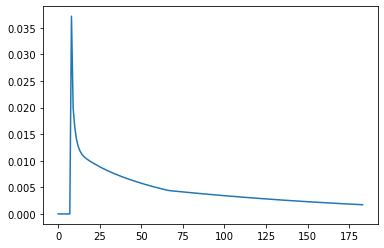

In [96]:
plt.plot(Dist1[2:])

In [97]:
dist = pd.DataFrame(Dist1)

In [98]:
dist[0]

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
181    0.001790
182    0.001775
183    0.001759
184    0.001744
185    0.001729
Name: 0, Length: 186, dtype: float64

In [24]:
dist2 = pd.DataFrame()

In [25]:
dist2['nominal HEP'] =Dist1

In [29]:
dist2['r=0.9, e=0.3'] = dist[0] 

In [38]:
dist2['r=0.6,e=0.1'] =dist[0]

In [41]:
dist2.drop('nominal HEP',inplace=True,axis=1)

In [55]:
dist2['F=20, r=0.9,e=0.3'] =dist[0]

In [99]:
dist2['F=10, r=0.9,e=0.3'] =dist[0]

In [67]:
dist2['F=2, r=0.9, e=0.3'][0]

0.0

In [100]:
import matplotlib as mpl
import numpy as np
# create valid markers from mpl.markers
valid_markers = ([item[0] for item in mpl.markers.MarkerStyle.markers.items() if
item[1] is not 'nothing' and not item[1].startswith('tick') and not item[1].startswith('caret')])
 
# valid_markers = mpl.markers.MarkerStyle.filled_markers
 
markers = np.random.choice(valid_markers, dist2.shape[1], replace=False)


<>:5: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:5: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-100-41ce5dd92d9b>:5: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  item[1] is not 'nothing' and not item[1].startswith('tick') and not item[1].startswith('caret')])


In [101]:
 dist2.replace(0, np.nan,inplace=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


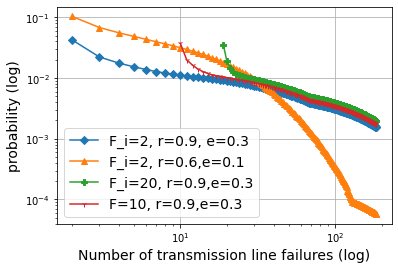

In [102]:
ax=dist2.plot(loglog=True, grid='on')
plt.xlabel('Number of transmission line failures (log)',fontsize=14)
plt.ylabel('probability (log)',fontsize=14)
plt.legend(fontsize=14)
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])
ax.legend(ax.get_lines(), dist2.columns, loc='best',fontsize=14)
plt.savefig('initial.eps',format='eps')


In [79]:
dist2.columns = ['F_i=2, r=0.9, e=0.3', 'F_i=2, r=0.6,e=0.1', 'F_i=20, r=0.9,e=0.3']

<AxesSubplot:>

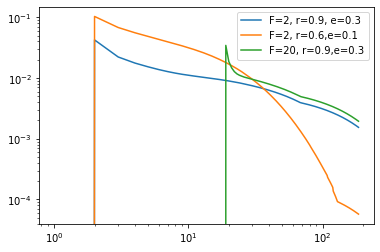

In [73]:
dist2.plot(loglog=True)

In [9]:
dist2[2:186].plot()
plt.xlabel('Number of transmission line failures')
plt.ylabel('Probability')
plt.savefig('fig5.eps',format='eps')

NameError: name 'dist2' is not defined